In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


class Analysis():
    """
    """

    def __init__(self, path_to_dir):
        self.path = path_to_dir
        
        separated_data = {
                'episode_reward': [],
                'loss': [],
                'runtime': [],
                'params_gradients': [],
                'input_params_gradients': []
            }

        # Walk through all directories and subdirectories in the root directory
        for subdir, dirs, files in os.walk(self.path):
            for file in files:
                if file.endswith('.npz'):
                    # Construct full file path
                    file_path = os.path.join(subdir, file)
                    
                    # Load the .npz file if it exists
                    if os.path.exists(file_path):
                        data = np.load(file_path, allow_pickle=True)
                        
                        # Append the data from this file to the respective lists in the separated data dictionary
                        for key in separated_data:
                            if key in data:
                                # Append each file's data as a new list within the main list
                                separated_data[key].append(data[key].tolist())

        self.data = separated_data
       
    def get_rewards(self):
        return self.data["episode_reward"]
    
    def get_loss(self):
        return self.data["loss"]
    
    def get_runtime(self):
        return self.data["runtime"]
    
    def get_gradients(self):
        print(self.data["params_gradients"])
        return self.data["params_gradients"] 
    
    def get_input_gradients(self):
        return self.data["input_params_gradients"]

    def get_moving_average(self, window_size = 10):
        rewards = self.get_rewards()
        moving_averages = []
        for reward in rewards:
            moving_averages.append(pd.Series(reward).rolling(window_size).mean())
        return moving_averages
    
    def calculate_mean_variance_gradients(self, return_max = False, return_min = False):
        gradients = self.get_gradients()
        min_length = min([len(gradients[i]) for i in range(len(gradients))])

        gradients = [gradients[i][:min_length] for i in range(len(gradients))]

        def flatten_gradients(gradients):
            for i in range(len(gradients)):
                for j in range(len(gradients[i])):
                    if i == 0:
                        print(gradients[i][j][0])
                    gradients[i][j] = np.concatenate([lista.flatten() for lista in gradients[i][j]], axis = 0)

        flatten_gradients(gradients)

        gradients_array = np.array(gradients)

        magnitudes_gradients = np.linalg.norm(gradients_array, axis = 2)

        mean_magnitudes_gradients = np.mean(magnitudes_gradients, axis = 0)

        std_magnitudes_gradients = np.var(magnitudes_gradients, axis = 0)

        max_magnitudes_gradients = np.max(magnitudes_gradients, axis = 0)

        min_magnitudes_gradients = np.min(magnitudes_gradients, axis = 0)

        max_index = np.argmax(gradients_array, axis = 2)

        min_index = np.argmin(gradients_array, axis = 2)

        if return_max and return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index, min_magnitudes_gradients, min_index
        elif return_max:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index
        elif return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, min_magnitudes_gradients, min_index
        else:
            return mean_magnitudes_gradients, std_magnitudes_gradients
        
    def calculate_mean_variance_input_gradients(self, return_max = False, return_min = False):
        gradients = self.get_input_gradients()
        min_length = min([len(gradients[i]) for i in range(len(gradients))])

        gradients = [gradients[i][:min_length] for i in range(len(gradients))]

        def flatten_gradients(gradients):
            for i in range(len(gradients)):
                for j in range(len(gradients[i])):
                    gradients[i][j] = np.concatenate([lista.flatten() for lista in gradients[i][j]], axis = 0)

        flatten_gradients(gradients)

        gradients_array = np.array(gradients)

        magnitudes_gradients = np.linalg.norm(gradients_array, axis = 2)

        mean_magnitudes_gradients = np.mean(magnitudes_gradients, axis = 0)

        std_magnitudes_gradients = np.var(magnitudes_gradients, axis = 0)

        max_magnitudes_gradients = np.max(magnitudes_gradients, axis = 0)

        min_magnitudes_gradients = np.min(magnitudes_gradients, axis = 0)

        max_index = np.argmax(gradients_array, axis = 2)

        min_index = np.argmin(gradients_array, axis = 2)

        if return_max and return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index, min_magnitudes_gradients, min_index
        elif return_max:
            return mean_magnitudes_gradients, std_magnitudes_gradients, max_magnitudes_gradients, max_index
        elif return_min:
            return mean_magnitudes_gradients, std_magnitudes_gradients, min_magnitudes_gradients, min_index
        else:
            return mean_magnitudes_gradients, std_magnitudes_gradients
        

In [4]:
raw_contiguous_1layer_path = "../../../../data/CartPole-v1/raw_contiguous_1layer"
raw_contiguous_4layer_path = "../../../../data/CartPole-v1/raw_contiguous_4layer"
raw_contiguous_6layer_path = "../../../../data/CartPole-v1/raw_contiguous_6layer"
raw_contiguous_8layer_path = "../../../../data/CartPole-v1/raw_contiguous_8layer"
raw_parity_1layer_path = "../../../../data/CartPole-v1/raw_parity_1layer"
raw_parity_4layer_path = "../../../../data/CartPole-v1/raw_parity_4layer"
raw_parity_6layer_path = "../../../../data/CartPole-v1/raw_parity_6layer"
raw_parity_8layer_path = "../../../../data/CartPole-v1/raw_parity_8layer"
softmax_1layer_path = "../../../../data/CartPole-v1/softmax_1layer"
softmax_4layer_path = "../../../../data/CartPole-v1/softmax_4layer"
softmax_6layer_path = "../../../../data/CartPole-v1/softmax_6layer"
softmax_8layer_path = "../../../../data/CartPole-v1/softmax_8layer"
softmax_1layer_probs_path = "../../../../data/CartPole-v1/softmax_1layer_probs"
softmax_4layer_probs_path = "../../../../data/CartPole-v1/softmax_4layer_probs"
softmax_6layer_probs_path = "../../../../data/CartPole-v1/softmax_6layer_probs"
softmax_8layer_probs_path = "../../../../data/CartPole-v1/softmax_8layer_probs"

raw_contiguous_1layer = Analysis(raw_contiguous_1layer_path)
raw_contiguous_4layer = Analysis(raw_contiguous_4layer_path)
raw_contiguous_6layer = Analysis(raw_contiguous_6layer_path)
raw_contiguous_8layer = Analysis(raw_contiguous_8layer_path)
raw_parity_1layer = Analysis(raw_parity_1layer_path)
raw_parity_4layer = Analysis(raw_parity_4layer_path)
raw_parity_6layer = Analysis(raw_parity_6layer_path)
raw_parity_8layer = Analysis(raw_parity_8layer_path)
softmax_1layer = Analysis(softmax_1layer_path)
softmax_4layer = Analysis(softmax_4layer_path)
softmax_6layer = Analysis(softmax_6layer_path)
softmax_8layer = Analysis(softmax_8layer_path)
softmax_1layer_probs = Analysis(softmax_1layer_probs_path)
softmax_4layer_probs = Analysis(softmax_4layer_probs_path)
softmax_6layer_probs = Analysis(softmax_6layer_probs_path)
softmax_8layer_probs = Analysis(softmax_8layer_probs_path)

# Rewards


In [5]:
raw_contiguous_1layer_returns = raw_contiguous_1layer.get_rewards()
raw_contiguous_4layer_returns = raw_contiguous_4layer.get_rewards()
raw_contiguous_6layer_returns = raw_contiguous_6layer.get_rewards()
raw_contiguous_8layer_returns = raw_contiguous_8layer.get_rewards()
raw_parity_1layer_returns = raw_parity_1layer.get_rewards()
raw_parity_4layer_returns = raw_parity_4layer.get_rewards()
raw_parity_6layer_returns = raw_parity_6layer.get_rewards()
raw_parity_8layer_returns = raw_parity_8layer.get_rewards()
softmax_1layer_returns = softmax_1layer.get_rewards()
softmax_4layer_returns = softmax_4layer.get_rewards()
softmax_6layer_returns = softmax_6layer.get_rewards()
softmax_8layer_returns = softmax_8layer.get_rewards()
softmax_1layer_probs_returns = softmax_1layer_probs.get_rewards()
softmax_4layer_probs_returns = softmax_4layer_probs.get_rewards()
softmax_6layer_probs_returns = softmax_6layer_probs.get_rewards()
softmax_8layer_probs_returns = softmax_8layer_probs.get_rewards()

raw_contiguous_1layer_returns_mean = np.mean(raw_contiguous_1layer_returns, axis=0)
raw_contiguous_4layer_returns_mean = np.mean(raw_contiguous_4layer_returns, axis=0)
raw_contiguous_6layer_returns_mean = np.mean(raw_contiguous_6layer_returns, axis=0)
raw_contiguous_8layer_returns_mean = np.mean(raw_contiguous_8layer_returns, axis=0)
raw_parity_1layer_returns_mean = np.mean(raw_parity_1layer_returns, axis=0)
raw_parity_4layer_returns_mean = np.mean(raw_parity_4layer_returns, axis=0)
raw_parity_6layer_returns_mean = np.mean(raw_parity_6layer_returns, axis=0)
raw_parity_8layer_returns_mean = np.mean(raw_parity_8layer_returns, axis=0)
softmax_1layer_returns_mean = np.mean(softmax_1layer_returns, axis=0)
softmax_4layer_returns_mean = np.mean(softmax_4layer_returns, axis=0)
softmax_6layer_returns_mean = np.mean(softmax_6layer_returns, axis=0)
softmax_8layer_returns_mean = np.mean(softmax_8layer_returns, axis=0)
softmax_1layer_probs_returns_mean = np.mean(softmax_1layer_probs_returns, axis=0)
softmax_4layer_probs_returns_mean = np.mean(softmax_4layer_probs_returns, axis=0)
softmax_6layer_probs_returns_mean = np.mean(softmax_6layer_probs_returns, axis=0)
softmax_8layer_probs_returns_mean = np.mean(softmax_8layer_probs_returns, axis=0)

raw_contiguous_1layer_returns_std = np.std(raw_contiguous_1layer_returns, axis=0)
raw_contiguous_4layer_returns_std = np.std(raw_contiguous_4layer_returns, axis=0)
raw_contiguous_6layer_returns_std = np.std(raw_contiguous_6layer_returns, axis=0)
raw_contiguous_8layer_returns_std = np.std(raw_contiguous_8layer_returns, axis=0)
raw_parity_1layer_returns_std = np.std(raw_parity_1layer_returns, axis=0)
raw_parity_4layer_returns_std = np.std(raw_parity_4layer_returns, axis=0)
raw_parity_6layer_returns_std = np.std(raw_parity_6layer_returns, axis=0)
raw_parity_8layer_returns_std = np.std(raw_parity_8layer_returns, axis=0)
softmax_1layer_returns_std = np.std(softmax_1layer_returns, axis=0)
softmax_4layer_returns_std = np.std(softmax_4layer_returns, axis=0)
softmax_6layer_returns_std = np.std(softmax_6layer_returns, axis=0)
softmax_8layer_returns_std = np.std(softmax_8layer_returns, axis=0)
softmax_1layer_probs_returns_std = np.std(softmax_1layer_probs_returns, axis=0)
softmax_4layer_probs_returns_std = np.std(softmax_4layer_probs_returns, axis=0)
softmax_6layer_probs_returns_std = np.std(softmax_6layer_probs_returns, axis=0)
softmax_8layer_probs_returns_std = np.std(softmax_8layer_probs_returns, axis=0)

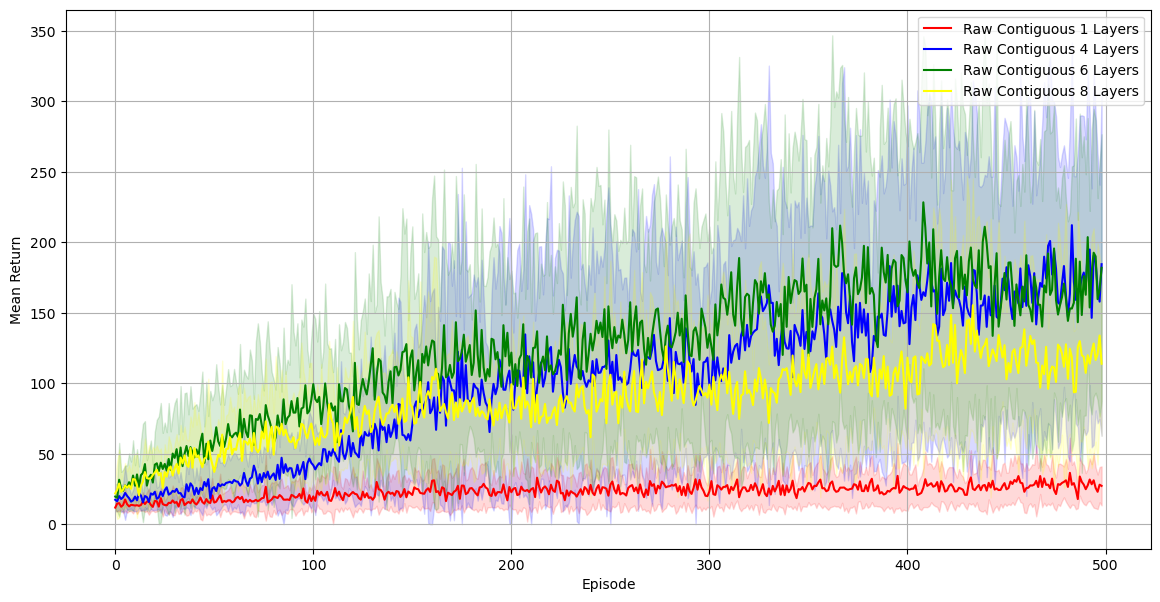

In [6]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_contiguous_1layer_returns_mean,color = "red", label="Raw Contiguous 1 Layers")
plt.plot(raw_contiguous_4layer_returns_mean,color = "blue", label="Raw Contiguous 4 Layers")
plt.plot(raw_contiguous_6layer_returns_mean,color = "green", label="Raw Contiguous 6 Layers")
plt.plot(raw_contiguous_8layer_returns_mean,color = "yellow", label="Raw Contiguous 8 Layers")

plt.fill_between(np.arange(len(raw_contiguous_1layer_returns_mean)), np.clip(raw_contiguous_1layer_returns_mean - raw_contiguous_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_1layer_returns_mean + raw_contiguous_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_contiguous_4layer_returns_mean)), np.clip(raw_contiguous_4layer_returns_mean - raw_contiguous_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_4layer_returns_mean + raw_contiguous_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_contiguous_6layer_returns_mean)), np.clip(raw_contiguous_6layer_returns_mean - raw_contiguous_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_6layer_returns_mean + raw_contiguous_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_contiguous_8layer_returns_mean)), np.clip(raw_contiguous_8layer_returns_mean - raw_contiguous_8layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_8layer_returns_mean + raw_contiguous_8layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

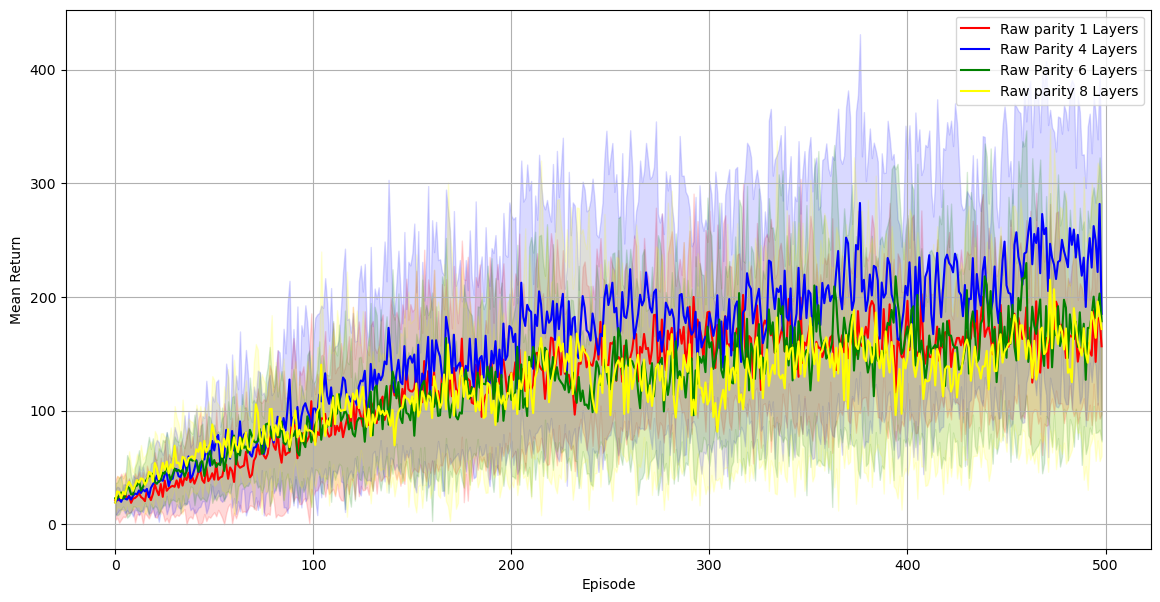

In [7]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_parity_1layer_returns_mean,color = "red", label="Raw Parity 1 Layers")
plt.plot(raw_parity_4layer_returns_mean,color = "blue", label="Raw Parity 4 Layers")
plt.plot(raw_parity_6layer_returns_mean,color = "green", label="Raw Parity 6 Layers")
plt.plot(raw_parity_8layer_returns_mean,color = "yellow", label="Raw Parity 8 Layers")

plt.fill_between(np.arange(len(raw_parity_1layer_returns_mean)), np.clip(raw_parity_1layer_returns_mean - raw_parity_1layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_1layer_returns_mean + raw_parity_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_parity_4layer_returns_mean)), np.clip(raw_parity_4layer_returns_mean - raw_parity_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_4layer_returns_mean + raw_parity_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(raw_parity_6layer_returns_mean)), np.clip(raw_parity_6layer_returns_mean - raw_parity_6layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_6layer_returns_mean + raw_parity_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(raw_parity_8layer_returns_mean)), np.clip(raw_parity_8layer_returns_mean - raw_parity_8layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_8layer_returns_mean + raw_parity_8layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

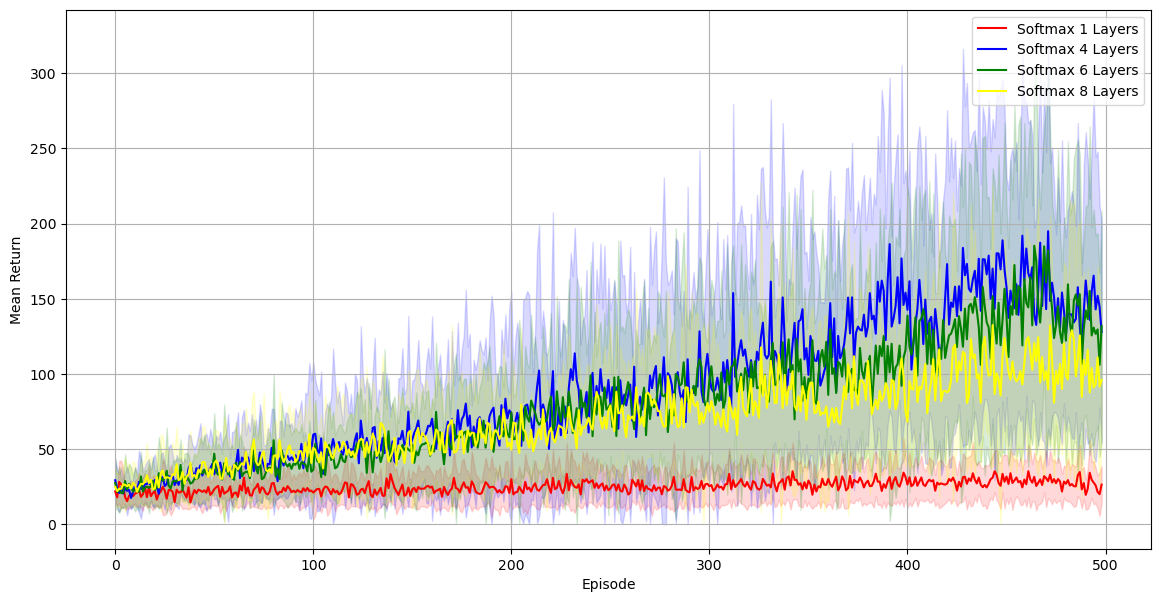

In [10]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(softmax_1layer_returns_mean,color = "red", label="Softmax 1 Layers")
plt.plot(softmax_4layer_returns_mean,color = "blue", label="Softmax 4 Layers")
plt.plot(softmax_6layer_returns_mean,color = "green", label="Softmax 6 Layers")
plt.plot(softmax_8layer_returns_mean,color = "yellow", label="Softmax 8 Layers")

plt.fill_between(np.arange(len(softmax_1layer_returns_mean)), np.clip(softmax_1layer_returns_mean - softmax_1layer_returns_std,a_min=0,a_max=500), np.clip(softmax_1layer_returns_mean + softmax_1layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(softmax_4layer_returns_mean)), np.clip(softmax_4layer_returns_mean - softmax_4layer_returns_std,a_min=0,a_max=500), np.clip(softmax_4layer_returns_mean + softmax_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(softmax_6layer_returns_mean)), np.clip(softmax_6layer_returns_mean - softmax_6layer_returns_std,a_min=0,a_max=500), np.clip(softmax_6layer_returns_mean + softmax_6layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(softmax_8layer_returns_mean)), np.clip(softmax_8layer_returns_mean - softmax_8layer_returns_std,a_min=0,a_max=500), np.clip(softmax_8layer_returns_mean + softmax_8layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")
plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

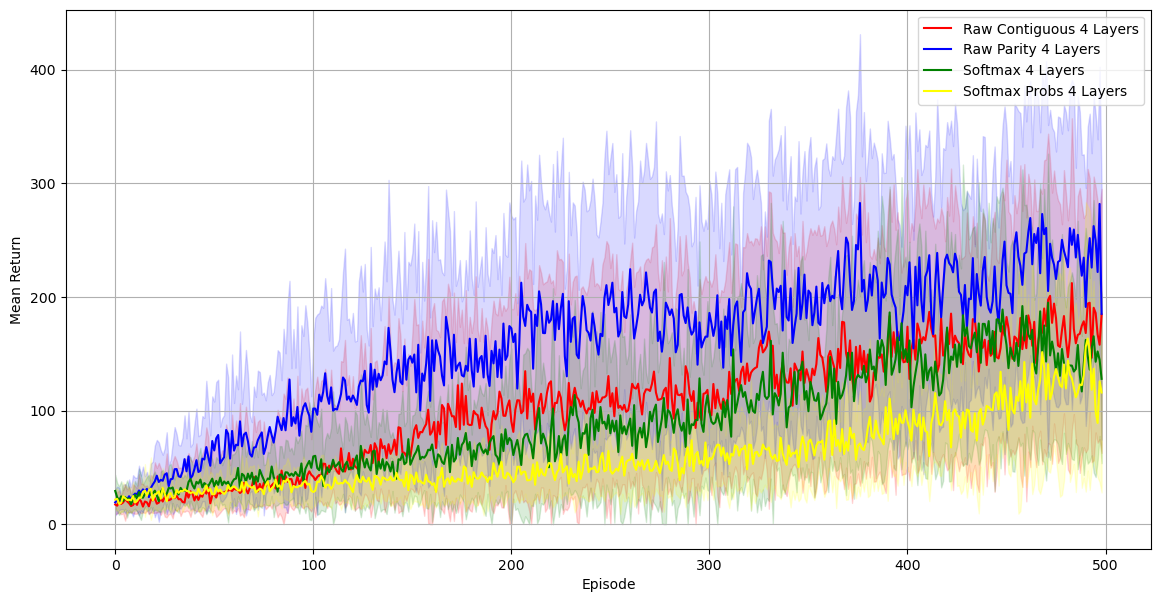

In [11]:
plt.rcParams['figure.figsize'] = [14, 7]

plt.plot(raw_contiguous_4layer_returns_mean,color = "red", label="Raw Contiguous 4 Layers")
plt.plot(raw_parity_4layer_returns_mean,color = "blue", label="Raw Parity 4 Layers")
plt.plot(softmax_4layer_returns_mean,color = "green", label="Softmax 4 Layers")
plt.plot(softmax_4layer_probs_returns_mean,color = "yellow", label="Softmax Probs 4 Layers")

plt.fill_between(np.arange(len(raw_contiguous_4layer_returns_mean)), np.clip(raw_contiguous_4layer_returns_mean - raw_contiguous_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_contiguous_4layer_returns_mean + raw_parity_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="red")
plt.fill_between(np.arange(len(raw_parity_4layer_returns_mean)), np.clip(raw_parity_4layer_returns_mean - raw_parity_4layer_returns_std,a_min=0,a_max=500), np.clip(raw_parity_4layer_returns_mean + raw_parity_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="blue")
plt.fill_between(np.arange(len(softmax_4layer_returns_mean)), np.clip(softmax_4layer_returns_mean - softmax_4layer_returns_std,a_min=0,a_max=500), np.clip(softmax_4layer_returns_mean + softmax_4layer_returns_std, a_min = None, a_max = 500), alpha=0.15, color="green")
plt.fill_between(np.arange(len(softmax_4layer_probs_returns_mean)), np.clip(softmax_4layer_probs_returns_mean - softmax_4layer_probs_returns_std,a_min=0,a_max=500), np.clip(softmax_4layer_probs_returns_mean + softmax_4layer_probs_returns_std, a_min = None, a_max = 500), alpha=0.15, color="yellow")

plt.xlabel("Episode")
plt.ylabel("Mean Return")
plt.legend(loc = "upper right")
plt.grid(True)
#plt.savefig('../../graphs/skolik_baseline.pdf')  
plt.show()

# Gradients

In [52]:
raw_contiguous_1layer_gradients = raw_contiguous_1layer.calculate_mean_variance_gradients()
raw_contiguous_4layer_gradients = raw_contiguous_4layer.calculate_mean_variance_gradients()
raw_contiguous_6layer_gradients = raw_contiguous_6layer.calculate_mean_variance_gradients()
raw_contiguous_8layer_gradients = raw_contiguous_8layer.calculate_mean_variance_gradients()
#raw_parity_1layer_gradients = raw_parity_1layer.calculate_mean_variance_gradients()
raw_parity_4layer_gradients = raw_parity_4layer.calculate_mean_variance_gradients()
raw_parity_6layer_gradients = raw_parity_6layer.calculate_mean_variance_gradients()
#raw_parity_8layer_gradients = raw_parity_8layer.calculate_mean_variance_gradients()

raw_contiguous_1layer_input_gradients = raw_contiguous_1layer.calculate_mean_variance_input_gradients()
raw_contiguous_4layer_input_gradients = raw_contiguous_4layer.calculate_mean_variance_input_gradients()
raw_contiguous_6layer_input_gradients = raw_contiguous_6layer.calculate_mean_variance_input_gradients()
raw_contiguous_8layer_input_gradients = raw_contiguous_8layer.calculate_mean_variance_input_gradients()
#raw_parity_1layer_input_gradients = raw_parity_1layer.calculate_mean_variance_input_gradients()
raw_parity_4layer_input_gradients = raw_parity_4layer.calculate_mean_variance_input_gradients()
raw_parity_6layer_input_gradients = raw_parity_6layer.calculate_mean_variance_input_gradients()
#raw_parity_8layer_input_gradients = raw_parity_8layer.calculate_mean_variance_input_gradients()

[[[3.961090326309204, 3.2552287578582764, -0.2785375416278839, 0.12770625948905945, 9.368270781351384e-08, 1.6959020854301343e-07, -2.347335055219446e-07, -7.939004831314378e-08, 1.5990467071533203, 3.787626266479492, -5.7480065152049065e-09, -3.59461509447101e-08, -5.5641066865064204e-08, 1.1137424849039235e-07, -7.166499926825054e-08, 5.614068498971392e-08], [-1.5204570293426514, -0.8991311192512512, 0.04161933809518814, -0.017993485555052757, 1.3900699968871777e-07, -2.3068848520324536e-07, 1.3167020540549856e-07, 1.8181836480835045e-08, -0.5589035749435425, -1.1717004776000977, -1.5774276107549667e-08, -4.273796960774234e-08, 1.5581463230773807e-08, 1.0783023185467755e-07, -1.2245664038346149e-08, -6.837943544724112e-10], [1.7603594064712524, 0.8770202994346619, -0.019099637866020203, 0.007951391860842705, 8.910872395517799e-08, 3.694007588705972e-08, -4.7717838569383275e-09, -7.333876084203439e-08, 0.6228448152542114, 1.2331500053405762, 1.2136297300457954e-08, -6.653981188264879e

AttributeError: 'float' object has no attribute 'flatten'

# Directory check


In [8]:
current_directory = os.getcwd()

absolute_path = os.path.abspath(os.path.join(current_directory, "../../../../data/CartPole-v1/raw_contiguous_4layer"))

print(absolute_path)

c:\Users\Bernardo\Desktop\Work\data\CartPole-v1\raw_contiguous_4layer
